In [ ]:
pip install xgboost

In [ ]:
#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline


In [ ]:
data = pd.read_csv('Cleaning 2018 - 2019.csv')

In [ ]:
display(data.head())

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HST,AST,HF,AF,Average FTHG,Averager FTHGC,AverageFTAG,AverageFTAGC,HTGRA,HTGCRA,ATGRA,ATGCRA,AverageHTGRA,AverageHTGCRA,AverageATGRA,AverageATGCRA
0,E0,09/08/2019,Liverpool,Norwich,4,1,H,7,5,9,9,4.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E0,10/08/2019,West Ham,Man City,0,5,A,3,9,6,13,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E0,10/08/2019,Bournemouth,Sheffield United,1,1,D,3,3,10,19,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E0,10/08/2019,Burnley,Southampton,3,0,H,4,3,6,12,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E0,10/08/2019,Crystal Palace,Everton,0,0,D,2,3,16,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
del data['Div']
del data['Date']
del data['HomeTeam']
del data['AwayTeam']
del data['FTHG']
del data['FTAG']
del data['HST']
del data['AST']
del data['HF']
del data['AF']
del data['Average FTHG']
del data['Averager FTHGC']
del data['AverageFTAG']
del data['AverageFTAGC']
del data['HTGRA']
del data['HTGCRA']
del data['ATGRA']
del data['ATGCRA']


In [ ]:
#Everything should be 0 because these are week 1 games no average has been established.
display(data.head())

,FTR,AverageHTGRA,AverageHTGCRA,AverageATGRA,AverageATGCRA
0,H,0.0,0.0,0.0,0.0
1,A,0.0,0.0,0.0,0.0
2,D,0.0,0.0,0.0,0.0
3,H,0.0,0.0,0.0,0.0
4,D,0.0,0.0,0.0,0.0


In [ ]:

#what is the win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print ("Total number of matches:",n_matches)
print ("Number of features:",n_features)
print ("Number of matches won by home team",n_homewins)
print ("Win rate of home team:",win_rate,"%")

Total number of matches: 380
Number of features: 4
Number of matches won by home team 172
Win rate of home team: 45.26315789473684 %


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8b7b550f0>,
      dtype=object)

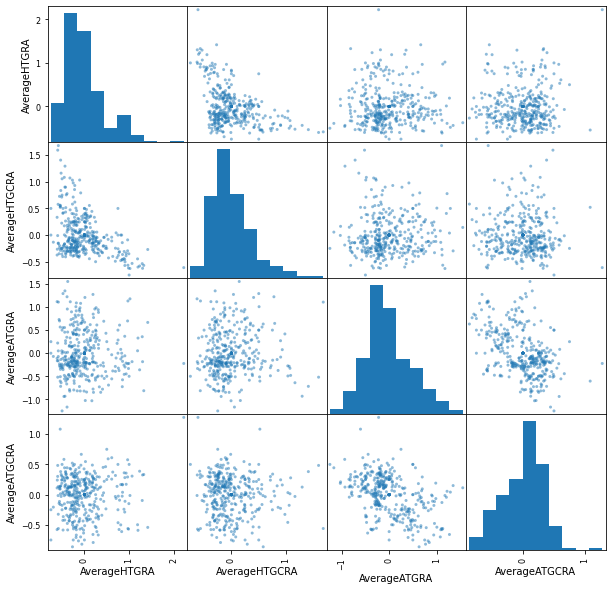

In [ ]:
# Visualising distribution of data
from pandas.plotting import scatter_matrix

#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#Average HTGRA - Average home team goals relative to average, how many more or less goals does the home team score against relative to the visiting teams away goals conceded average
#Average HTGCRA - Average home team goals conceded relative to average
#Average ATGRA - Average away team goals scored relative to average
#Average ATGCRA - Average away team goals scored relative to average


scatter_matrix(data[['AverageHTGRA','AverageHTGCRA','AverageATGRA','AverageATGCRA']], figsize=(10,10))

In [ ]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['AverageHTGRA','AverageHTGCRA','AverageATGRA','AverageATGCRA']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [ ]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_all)

In [ ]:

#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in",end - start, "seconds")

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in" ,end - start, "seconds")
    
    return f1_score(target, y_pred, pos_label='H',average='micro'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a",clf.__class__.__name__, "using a training set size of",len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set:", f1 , acc)
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set:", f1 , acc)

In [ ]:

# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ('')

Training a LogisticRegression using a training set size of 330
Trained model in 0.023496150970458984 seconds
Made predictions in 0.0016634464263916016 seconds
0.6242424242424243 0.6242424242424243
F1 score and accuracy score for training set: 0.6242424242424243 0.6242424242424243
Made predictions in 0.0008764266967773438 seconds
F1 score and accuracy score for test set: 0.62 0.62

Training a SVC using a training set size of 330
Trained model in 0.00832676887512207 seconds
Made predictions in 0.0043065547943115234 seconds
0.6575757575757576 0.6575757575757576
F1 score and accuracy score for training set: 0.6575757575757576 0.6575757575757576
Made predictions in 0.0015187263488769531 seconds
F1 score and accuracy score for test set: 0.52 0.52

Training a XGBClassifier using a training set size of 330


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'H') is ignored when average !

Trained model in 0.2559397220611572 seconds
Made predictions in 0.006954669952392578 seconds
0.8666666666666667 0.8666666666666667
F1 score and accuracy score for training set: 0.8666666666666667 0.8666666666666667
Made predictions in 0.002603292465209961 seconds
F1 score and accuracy score for test set: 0.41999999999999993 0.42



In [ ]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H',average='micro')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print (clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1 score and accuracy score for training set:", f1 , acc)
    
f1, acc = predict_labels(clf, X_test, y_test)
print ("F1 score and accuracy score for test set:", f1 , acc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=2,
              silent=None, subsample=0.8, verbosity=1)
Made predictions in 0.003288745880126953 seconds
F1 score and accuracy score for training set: 0.7606060606060606 0.7606060606060606
Made predictions in 0.0022192001342773438 seconds
F1 score and accuracy score for test set: 0.5 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
